# Content-based Filtering

## Dependencies

In [115]:
# preprocessing
import pandas as pd
import re
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.data.path.append("/home/albot/coding/repos/Machine-learning-AI24/data/movielens/nltk_data/")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
# # RUN DOWNLOADS ONLY ONCE
# nltk.download("vader_lexicon")
# nltk.download("stopwords")

## Preprocessing

### Movies

In [149]:
movies = pd.read_csv("../data/movielens/movies.csv")

In [150]:
movies.head(2)

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [151]:
movies["genres"] = movies["genres"].replace("(no genres listed)", np.nan)
movies["genres"] = movies["genres"].str.lower().str.replace("|", " ").str.replace("-", "").str.strip()
# movies["year"] = movies["title"].str.extract(r"\((\d{4})\)")
# movies["title"] = movies["title"].str.replace(r'\[.*?\]|\(.*?\)', '', regex=True).str.strip()
movies.dropna(how="any", inplace=True) # dropping 7300 NaN values

In [152]:
movies.head(2)

,movie_id,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy


In [153]:
movies_gen = movies.copy()
movies_gen = movies_gen.drop(columns=["title"]) #, "year"])

In [154]:
movies_gen.head(2)

,movie_id,genres
0,1,adventure animation children comedy fantasy
1,2,adventure children fantasy


### Tags

In [74]:
stop_words = stopwords.words("english")
more_stopwords = []  # add internet slang, etc.
# stop_words = stop_words + more_stopwords
stemmer = nltk.SnowballStemmer("english")


# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers."""
    text = str(text).lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\n", "", text)
    text = re.sub(r"\w*\d\w*", "", text)
    return text


def remove_stopwords(text):
    text = " ".join(word for word in text.split(" ") if word not in stop_words)
    return text


def stem_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [75]:
tags = pd.read_csv("../data/movielens/tags.csv")
movies_tag = tags.copy()
movies_tag = movies_tag.drop(columns=["user_id", "timestamp"])
movies_tag = movies_tag.groupby('movie_id')['tag'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
movies_tag["tag"] = movies_tag["tag"].apply(remove_stopwords)
movies_tag["tag"] = movies_tag["tag"].apply(clean_text)
movies_tag["tag"] = movies_tag["tag"].apply(stem_text)

In [76]:
movies_tag

,movie_id,tag
0,1,anim friendship toy anim disney pixar toy cgi ...
1,2,anim base book fantasi magic board game monkey...
2,3,sequel moldi old old age old men wed old peopl...
3,4,charact chick flick girl movi charact chick fl...
4,5,famili pregnanc wed wall age babi daughter di...
...,...,...
53447,288765,postapocalypt surviv tw suicid apocalyps bad s...
53448,288779,don camillo seri
53449,288849,addict anim short film
53450,288937,anim


### Combining tags and movies

In [155]:
movies_gentag = movies_gen.merge(movies_tag, on="movie_id", how="left")
movies_gentag["semantics"] = movies_gentag.apply(lambda x: f"{x["genres"]} {x["tag"]}" if pd.notna(x["tag"]) else x["genres"], axis=1)
movies_gentag = movies_gentag.drop(columns=["genres", "tag"])

In [156]:
movies_gentag

,movie_id,semantics
0,1,adventure animation children comedy fantasy an...
1,2,adventure children fantasy anim base book fant...
2,3,comedy romance sequel moldi old old age old me...
3,4,comedy drama romance charact chick flick girl ...
4,5,comedy famili pregnanc wed wall age babi daug...
...,...,...
79472,288967,action drama
79473,288971,action horror
79474,288975,documentary
79475,288977,crime thriller


### Dimensionality reduction

?

### TF-IDF

In [79]:
tfidf = TfidfVectorizer(min_df=2)
tfidf_matrix = tfidf.fit_transform(movies_gentag["semantics"])
tfidf_vocab = tfidf.get_feature_names_out()

In [80]:
def get_recommendations(movie_id, n=5):
    idx = movies_gentag[movies_gentag["movie_id"] == movie_id].index[0]
    distances, indices = knn.kneighbors(tfidf_matrix[idx], n_neighbors=n+1)
    return movies_gentag.iloc[indices[0][1:]]

In [81]:
knn = NearestNeighbors(
    n_neighbors=6,
    metric="cosine",
    algorithm="brute"
)
knn.fit(tfidf_matrix)
temp = get_recommendations(344, 5) # 344 = Ace Ventura: Pet Detective (1994)
temp = temp["movie_id"].tolist()
temp = movies[movies["movie_id"].isin(temp)]
temp = temp["title"].tolist()
for i in temp:
    print(i)

Ace Ventura: When Nature Calls
Dumb & Dumber
Mask, The
Liar Liar
Me, Myself & Irene


### LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cvec_vocab = CountVectorizer(vocabulary=tfidf.vocabulary_)
vocab_matrix = cvec_vocab.fit_transform(movies_gentag["semantics"])

lda = LatentDirichletAllocation(
    n_components=20,
    max_iter=10,
    learning_method='online'
)
movie_topic_distributions = lda.fit_transform(vocab_matrix)

In [18]:
topic_df = pd.DataFrame(
    movie_topic_distributions, 
    index=movies_gentag['movie_id']
).reset_index()

In [19]:
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: age femal come school gay romanc high lead strong teenag
Topic 1: visual surreal appeal nuditi cinematographi atmospher beauti topless realiti altern
Topic 2: time travel action art polit postapocalypt martial spi car apocalyps
Topic 3: stori true base oscar best great pictur act inspir tom
Topic 4: death horror man murder shot woman femal charact car zombi
Topic 5: dark film social black commentari cult satir quirki noir white
Topic 6: relationship refer sex nuditi woman femal film male father mother
Topic 7: anim children animation comedy adventure fantasy disney short famili christma
Topic 8: horror end twist psycholog thriller mysteri suspens plot mental killer
Topic 9: crime thriller drama action mystery polic murder reveng prison corrupt
Topic 10: new thoughtprovok york citi dialogu philosophi philosoph driven russel smart
Topic 11: scifi space alien scienc intellig futur dystopia artifici robot travel
Topic 12: relationship famili emot bittersweet life love depress dram

In [20]:
topic_df

,movie_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,1,0.005246,0.001295,0.026599,0.108583,0.090583,0.000026,0.047736,0.502813,0.000026,...,0.001574,0.006249,0.002641,0.154539,0.039604,0.000026,0.004207,0.000727,0.006436,0.001062
1,2,0.022383,0.000045,0.117607,0.005098,0.198297,0.002464,0.071008,0.109638,0.000045,...,0.000045,0.002517,0.003081,0.011741,0.062544,0.000045,0.013748,0.010193,0.369414,0.000045
2,3,0.033043,0.000820,0.000820,0.053293,0.050435,0.000820,0.164099,0.000820,0.000820,...,0.378868,0.000820,0.000820,0.126785,0.051542,0.000820,0.000820,0.113549,0.000820,0.019370
3,4,0.450037,0.002000,0.002000,0.002000,0.002000,0.002000,0.217395,0.002000,0.002000,...,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.002000,0.190348,0.110220,0.002000
4,5,0.032472,0.000495,0.000495,0.000495,0.000495,0.000495,0.198269,0.000495,0.000495,...,0.063194,0.000495,0.206060,0.418551,0.000495,0.023666,0.000495,0.000495,0.051352,0.000495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79232,288967,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,...,0.016667,0.016667,0.016667,0.016667,0.350000,0.016667,0.016667,0.350000,0.016667,0.016667
79233,288971,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.350000,...,0.016667,0.016667,0.016667,0.016667,0.350000,0.016667,0.016667,0.016667,0.016667,0.016667
79234,288975,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.525000
79235,288977,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,...,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667


#### Evaluation

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(1, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []
for num in topic_nums:
    # NMF model initialization
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=0.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Coherence model calculation
    cm = CoherenceModel(
        model=nmf,
        texts=sep_prepr_titles,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    # Appending coherence scores to the list
    coherence_scores.append(round(cm.get_coherence(), 5))

The coherence score is a crucial metric in topic modeling that quantifies the quality and interpretability of topics generated by the NMF. It serves as an objective measure to assess the semantic consistency and relevance of words within a topic. By comparing the pairwise semantic similarity of the top words in a topic, coherence scores indicate whether the terms are closely related in meaning. Higher scores signify more coherent and interpretable topics, while lower scores suggest mixed or less focused topics.

In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)
plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## LSA

In [82]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=250)
lsa = svd.fit_transform(tfidf_matrix)

In [83]:
lsa_tfidf_df = pd.DataFrame(
    lsa,
    index=movies_gentag["movie_id"],
    columns=[f"topic_{i}" for i in range(250)]
)
lsa_tfidf_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_240,topic_241,topic_242,topic_243,topic_244,topic_245,topic_246,topic_247,topic_248,topic_249
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.010467,0.008603,0.001645,0.010171,0.001096,-0.015361,0.066063,-0.022555,0.002147,0.060713,...,-0.003097,-0.001774,-0.031704,-0.020146,-0.004586,0.034280,0.012004,0.003460,-0.016695,-0.002064
2,0.009144,0.004357,0.001980,0.020720,0.003380,0.000478,0.041285,0.000624,0.000608,0.037074,...,-0.019355,0.102062,0.070482,-0.032445,-0.018995,0.009282,-0.024125,0.022573,0.038518,0.131678
3,0.025716,0.032206,-0.001016,-0.001024,0.036179,0.002528,-0.000846,0.000787,0.002445,0.001764,...,0.016073,-0.015300,-0.028982,0.015785,0.004088,0.008865,-0.011424,-0.042330,0.008380,0.008761
4,0.097502,0.037161,-0.003469,-0.011820,0.068959,0.007480,-0.002176,-0.000491,0.003117,0.003132,...,0.014928,0.025034,0.017266,-0.005987,0.027335,-0.011666,0.048310,-0.027025,-0.013026,-0.019830
5,0.012577,0.016782,0.000144,0.002589,-0.001603,-0.000305,0.002448,0.000612,0.002171,0.006352,...,-0.042336,0.004343,0.040941,-0.017608,-0.018741,0.013270,-0.009360,-0.029184,-0.016839,0.036064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288967,0.504790,-0.255808,-0.007581,0.193000,-0.022367,-0.402980,0.194619,0.579540,-0.187268,-0.071348,...,-0.000465,0.000788,0.000485,-0.000071,-0.000193,0.000976,-0.000354,-0.000109,0.000086,0.000186
288971,0.097491,0.018338,0.002927,0.612686,0.021545,0.191931,0.301994,0.644114,-0.053065,-0.054036,...,-0.000398,0.000714,0.000358,-0.000326,-0.000015,0.000689,-0.000506,-0.000815,-0.000264,0.000643
288975,0.028118,0.022348,0.998436,-0.010612,0.002509,0.002319,-0.008292,0.000981,-0.006160,-0.003641,...,-0.000268,0.000040,0.000063,-0.000035,0.000063,-0.000247,-0.000195,-0.000156,0.000070,-0.000061


In [84]:
lsa_tfidf_df.shape

(79237, 250)

### HPO

In [48]:
n_topics = np.arange(10, 1000+1, 20)

var_ratio = []
for n in n_topics:
    print(f"\rFitting SVD with n_components: {n}", end="")
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit_transform(tfidf_matrix)
    explained_variance = svd.explained_variance_ratio_.sum()
    var_ratio.append(explained_variance)

Fitting SVD with n_components: 990

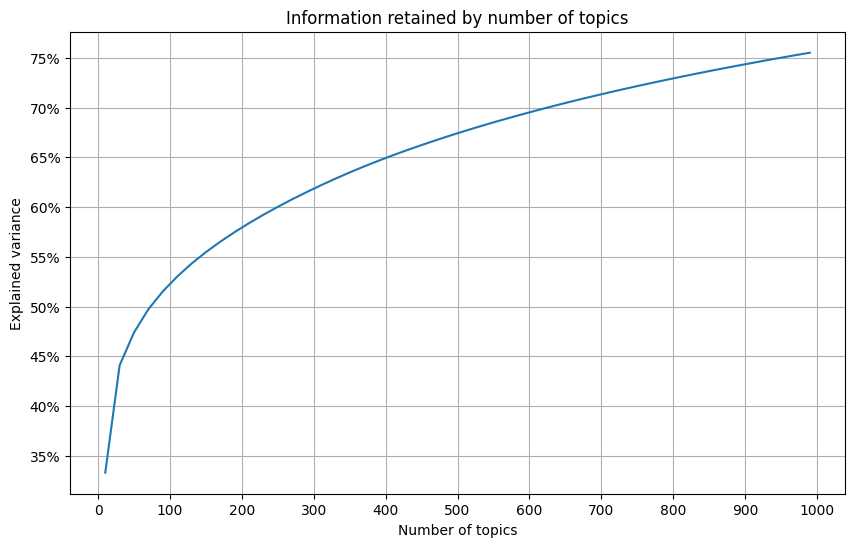

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=n_topics, y=var_ratio)
plt.title("Information retained by number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Explained variance")
# plt.xticks(n_topics[::4])
plt.xticks(range(0, 1001, 100))
rounded_var_ratio = [round(i * 20) / 20 for i in var_ratio]
plt.yticks(np.arange(rounded_var_ratio[0], rounded_var_ratio[-1] + 0.05, 0.05), 
           [f"{i:.0%}" for i in np.arange(rounded_var_ratio[0], rounded_var_ratio[-1] + 0.05, 0.05)])
plt.grid()
plt.show()

## Recommendation

In [85]:
H = lsa  # this is not correct but for the sake of using the same recommendation function
H.shape

(79237, 250)

In [56]:
pix = [152081, 134853, 6377]          # Zootopia, Inside Out, Finding Nemo
mix = [1, 79132, 171011]              # Toy Story, Inception, Planet Earth II

In [140]:
movie_mapper = {movie_id: idx for idx, movie_id in enumerate(movies_gentag["movie_id"])}
movie_mapper_reverse = {idx: movie_id for movie_id, idx in movie_mapper.items()}

In [169]:
input_movies = [58559]
n_recs = 10

input_indices = [movie_mapper[movie_id] for movie_id in input_movies]
input_matrix = H[input_indices, :]  # shape: (n_input_movies, n_factors)
similarity_scores = cosine_similarity(input_matrix, H)  # shape: (n_input_movies, n_all_movies)

# Find the highest similarity score for each candidate movie
similarity_scores = np.max(similarity_scores, axis=0)  # shape: (n_all_movies, )
similarity_scores[input_indices] = 0

# Sort the scores without affecting the order
sorted_scores = np.sort(similarity_scores)[::-1]
sorted_indices = np.argsort(similarity_scores)[::-1]
sorted_ids = [movie_mapper_reverse[idx] for idx in sorted_indices]

# Create a DataFrame with the top recommendations
movie_titles = [title for movie_id in sorted_ids[:n_recs] for title in movies[movies["movie_id"] == movie_id]["title"].values]
top_movies = [(movie, title, score) for movie, title, score in zip(sorted_ids, movie_titles, sorted_scores)][:n_recs]
top_df = pd.DataFrame(top_movies, columns=["movie_id", "title", "score"])
top_df = top_df.sort_values("score", ascending=False)



top_df



# np.max() = recommends movies similar to any of the input movies

,movie_id,title,score
0,33794,Batman Begins (2005),0.872237
1,592,Batman (1989),0.764431
2,1377,Batman Returns (1992),0.757670
3,91529,"Dark Knight Rises, The (2012)",0.706381
4,8636,Spider-Man 2 (2004),0.636231
5,3793,X-Men (2000),0.631373
6,3535,American Psycho (2000),0.630736
7,136864,Batman v Superman: Dawn of Justice (2016),0.629594
8,6157,Daredevil (2003),0.625104
9,2640,Superman (1978),0.613344
